# IMDb - Predicting actors' gender using getML

**Note that due to memory limitations, this notebook will not run on MyBinder.**

In this tutorial, we demonstrate how getML can be applied to text fields. In relational databases, text fields are less structured and less standardized than categorical data, making it more difficult to extract useful information from them. Therefore, they are ignored in most data science projects on relational data. However, when using a relational learning tool such as getML, we can easily generate simple features from text fields and leverage the information contained therein.

The point of this exercise is not to compete with modern deep-learning-based NLP approaches. The point is to develop an approach by which we can leverage fields in relational databases that would otherwise be ignored.

As an example data set, we use the Internet Movie Database, which has been used by previous studies in the relational learning literature. This allows us to benchmark our approach to state-of-the-art algorithms in the relational learning literature. We demonstrate that getML outperforms these state-of-the-art algorithms.

Summary:

- Prediction type: __Classification model__
- Domain: __Entertainment__
- Prediction target: __The gender of an actor__ 
- Population size: __817718__

_Author: Dr. Patrick Urbanke_

# Background

The data set contains about 800,000 actors. The goal is to predict the gender of said actors based on other information we have about them, such as the movies they have participated in and the roles they have played in these movies.

It has been downloaded from the [CTU Prague relational learning repository](https://relational.fit.cvut.cz/dataset/IMDb) (Motl and Schulte, 2015).

### A web frontend for getML

The getML monitor is a frontend built to support your work with getML. The getML monitor displays information such as the imported data frames, trained pipelines and allows easy data and feature exploration. You can launch the getML monitor [here](http://localhost:1709/listprojects/actors/).

### Where is this running?

Your getML live session is running inside a docker container on [mybinder.org](https://mybinder.org/), a service built by the Jupyter community and funded by Google Cloud, OVH, GESIS Notebooks and the Turing Institute. As it is a free service, this session will shut down after 10 minutes of inactivity.

# Analysis

Let's get started with the analysis and set up your session:

In [1]:
import copy
import os
from urllib import request

import numpy as np
import pandas as pd
from IPython.display import Image
import matplotlib.pyplot as plt
plt.style.use('seaborn')
%matplotlib inline  

import getml

getml.engine.set_project('imdb')


Loading pipelines...
[========================================] 100%

Connected to project 'imdb'


<span id='flags'></span>
In the following, we set some flags that affect execution of the notebook:
- We don't let the algorithms utilize the information on actors' first names (see [below](#first-names) for an explanation).
- Tuning is effective at improving our results, but it takes quite long, so we want to make it optional.

In [2]:
USE_FIRST_NAMES = False
USE_FINE_TUNED = False

## 1. Loading data

### 1.1 Download from source

We begin by downloading the data from the source file:

In [3]:
conn = getml.database.connect_mariadb(
    host="relational.fit.cvut.cz",
    dbname="imdb_ijs",
    port=3306,
    user="guest",
    password="relational"
)

conn

Connection(conn_id='default', dbname='imdb_ijs', dialect='mysql', 
           host='relational.fit.cvut.cz', port=3306)

In [4]:
def load_if_needed(name):
    """
    Loads the data from the relational learning
    repository, if the data frame has not already
    been loaded.
    """
    if not getml.data.exists(name):
        data_frame = getml.data.DataFrame.from_db(
            name=name,
            table_name=name,
            conn=conn
        )
        data_frame.save()
    else:
        data_frame = getml.data.load_data_frame(name)
    return data_frame

In [5]:
actors = load_if_needed("actors")
roles = load_if_needed("roles")
movies = load_if_needed("movies")
movies_genres = load_if_needed("movies_genres")

In [6]:
actors

Name,id,first_name,last_name,gender
Role,unused_float,unused_string,unused_string,unused_string
0,2,Michael,'babeepower' Viera,M
1,3,Eloy,'Chincheta',M
2,4,Dieguito,'El Cigala',M
3,5,Antonio,'El de Chipiona',M
4,6,José,'El Francés',M
,...,...,...,...
817713,845461,Herdís,Þorvaldsdóttir,F
817714,845462,Katla Margrét,Þorvaldsdóttir,F
817715,845463,Lilja Nótt,Þórarinsdóttir,F


In [7]:
roles

Name,actor_id,movie_id,role
Role,unused_float,unused_float,unused_string
0,2,280088,Stevie
1,2,396232,Various/lyricist
2,3,376687,Gitano 1
3,4,336265,El Cigala
4,5,135644,Himself
,...,...,...
3431961,845461,137097,Kata
3431962,845462,208838,Magga
3431963,845463,870,Gunna


In [8]:
movies

Name,id,year,rank,name
Role,unused_float,unused_float,unused_float,unused_string
0,0,2002,nan,#28
1,1,2000,nan,"#7 Train: An Immigrant Journey, The"
2,2,1971,6.4,$
3,3,1913,nan,"$1,000 Reward"
4,4,1915,nan,"$1,000 Reward"
,...,...,...,...
388264,412316,1991,nan,"""zem blch krlu"""
388265,412317,1995,nan,"""rgammk"""
388266,412318,2002,nan,"""zgnm Leyla"""


In [9]:
movies_genres

Name,movie_id,genre
Role,unused_float,unused_string
0,1,Documentary
1,1,Short
2,2,Comedy
3,2,Crime
4,5,Western
,...,...
395114,378612,Adventure
395115,378612,Drama
395116,378613,Comedy


### 1.2 Prepare data for getML

getML requires that we define *roles* for each of the columns.

In [10]:
actors["target"] = (actors.gender == 'F')
actors.set_role("id", getml.data.roles.join_key)
actors.set_role("target", getml.data.roles.target)

<span id='first-names'></span>
The benchmark studies do not state clearly, whether it is fair game to use the first names of the actors. Using the first names, we can easily increase the predictive accuracy to above 90%. However, when doing so the problem basically becomes a first name identification problem rather than a relational learning problem. This would undermine the point of this notebook: Showcase relational learning. Therefore, our assumption is that using the first names is not allowed. Feel free to set this flag [above](#flags) to see how well getML incoporates such starightforward information into its feature logic.

In [11]:
if USE_FIRST_NAMES:
    actors.set_role("first_name", getml.data.roles.text)
actors

Name,id,target,first_name,last_name,gender
Role,join_key,target,unused_string,unused_string,unused_string
0,2,0,Michael,'babeepower' Viera,M
1,3,0,Eloy,'Chincheta',M
2,4,0,Dieguito,'El Cigala',M
3,5,0,Antonio,'El de Chipiona',M
4,6,0,José,'El Francés',M
,...,...,...,...,...
817713,845461,1,Herdís,Þorvaldsdóttir,F
817714,845462,1,Katla Margrét,Þorvaldsdóttir,F
817715,845463,1,Lilja Nótt,Þórarinsdóttir,F


In [12]:
roles.set_role(["actor_id", "movie_id"], getml.data.roles.join_key)
roles.set_role("role", getml.data.roles.text)
roles

Name,actor_id,movie_id,role
Role,join_key,join_key,text
0,2,280088,Stevie
1,2,396232,Various/lyricist
2,3,376687,Gitano 1
3,4,336265,El Cigala
4,5,135644,Himself
,...,...,...
3431961,845461,137097,Kata
3431962,845462,208838,Magga
3431963,845463,870,Gunna


In [13]:
movies.set_role("id", getml.data.roles.join_key)
movies.set_role(["year", "rank"], getml.data.roles.numerical)
movies

Name,id,year,rank,name
Role,join_key,numerical,numerical,unused_string
0,0,2002,nan,#28
1,1,2000,nan,"#7 Train: An Immigrant Journey, The"
2,2,1971,6.4,$
3,3,1913,nan,"$1,000 Reward"
4,4,1915,nan,"$1,000 Reward"
,...,...,...,...
388264,412316,1991,nan,"""zem blch krlu"""
388265,412317,1995,nan,"""rgammk"""
388266,412318,2002,nan,"""zgnm Leyla"""


In [14]:
movies_genres.set_role("movie_id", getml.data.roles.join_key)
movies_genres.set_role("genre", getml.data.roles.categorical)
movies_genres

Name,movie_id,genre
Role,join_key,categorical
0,1,Documentary
1,1,Short
2,2,Comedy
3,2,Crime
4,5,Western
,...,...
395114,378612,Adventure
395115,378612,Drama
395116,378613,Comedy


We need to separate our data set into a training, testing and validation set:

In [15]:
random = actors.random()

is_training = (random < 0.7)
is_validation = (~is_training & (random < 0.85))
is_test = (~is_training & ~is_validation)

data_train = actors.where("data_train", is_training)
data_validation = actors.where("data_validation", is_validation)
data_test = actors.where("data_test", is_test)

## 2. Predictive modelling

We loaded the data and defined the roles and units. Next, we create a getML pipeline for relational learning.

### 2.1 Define relational model

To get started with relational learning, we need to specify the data model.

In [16]:
actors_ph = getml.data.Placeholder('actors')
roles_ph = getml.data.Placeholder('roles')
movies_ph = getml.data.Placeholder('movies')
movie_genres_ph = getml.data.Placeholder('movie_genres')

actors_ph.join(
    roles_ph,
    join_key='id',
    other_join_key='actor_id'
)

roles_ph.join(
    movies_ph,
    join_key='movie_id',
    other_join_key='id',
    relationship=getml.data.relationship.many_to_one
)

movies_ph.join(
    movie_genres_ph,
    join_key='id',
    other_join_key='movie_id'
)

actors_ph

placeholder   other placeholder   allow lagged targets   horizon   join keys used   memory   
actors        roles               False                  0.0       id               0.0      
roles         movies              False                  0.0       movie_id         0.0      
movies        movie_genres        False                  0.0       id               0.0      



other join keys used   other time stamps used   relationship   time stamps used   
actor_id                                        many-to-many                      
id                                              many-to-one                       
movie_id                                        many-to-many                      



other join keys used   upper time stamps used   
actor_id                                        
id                                              
movie_id

### 2.2 getML pipeline

<!-- #### 2.1.1  -->
__Set-up the feature learner & predictor__

We can either use the relboost default parameters or some more fine-tuned parameters. Fine-tuning these parameters in this way can increase our predictive accuracy to 85%, but the training time increases to over 4 hours. We therefore assume that we want to use the default parameters.

In [37]:
relboost = getml.feature_learning.RelboostModel(
    num_features=60,
    num_subfeatures=60,
    loss_function=getml.feature_learning.loss_functions.CrossEntropyLoss,
    seed=4367,
    num_threads=1,
    vocab_size=500 # TODO: Change to 30,000 to get the full performance
)

if USE_FINE_TUNED:
    relboost = getml.feature_learning.RelboostModel(
        num_features=60,
        num_subfeatures=20,
        loss_function=getml.feature_learning.loss_functions.CrossEntropyLoss,
        seed=4367,
        num_threads=1,
        sampling_factor=10,
        max_depth=6
    )
    
fast_prop = getml.feature_learning.FastPropModel(
    loss_function=getml.feature_learning.loss_functions.CrossEntropyLoss,
    vocab_size=50,
    sampling_factor=0.1
)
    
predictor = getml.predictors.XGBoostClassifier()

__Build the pipeline__

In [38]:
pipe = getml.pipeline.Pipeline(
    tags=['fast_prop'],
    population=actors_ph,
    peripheral=[roles_ph, movies_ph, movie_genres_ph],
    feature_learners=[fast_prop],
    predictors=[predictor]
)

### 2.3 Model training

In [34]:
peripheral = {
    "roles": roles, 
    "movies": movies, 
    "movie_genres": movies_genres
}

In [20]:
pipe.check(data_train, peripheral)

Checking data model...


INFO [JOIN KEYS NOT FOUND]: When joining the composite data frame 'roles'-'movies' that has been created by many-to-one joins or one-to-one joins and  data frame 'movie_genres' over 'id' and 'movie_id', there are no corresponding entries for 26.899421% of entries in 'id' in 'the composite data frame 'roles'-'movies' that has been created by many-to-one joins or one-to-one joins'. You might want to double-check your join keys.


In [ ]:
pipe.fit(data_train, peripheral)

Checking data model...


INFO [JOIN KEYS NOT FOUND]: When joining the composite data frame 'roles'-'movies' that has been created by many-to-one joins or one-to-one joins and  data frame 'movie_genres' over 'id' and 'movie_id', there are no corresponding entries for 26.899421% of entries in 'id' in 'the composite data frame 'roles'-'movies' that has been created by many-to-one joins or one-to-one joins'. You might want to double-check your join keys.



FastProp: Trying 441 features...
[========================================] 100%

FastProp: Building subfeatures...
[========================================] 100%

FastProp: Building features...
[========================================] 100%

XGBoost: Training as predictor...


### 2.4 Model evaluation

In [36]:
pipe.score(data_test, peripheral)


FastProp: Building subfeatures...
[========================================] 100%

FastProp: Building features...
[========================================] 100%



,date time,set used,target,accuracy,auc,cross entropy
0,2021-03-06 12:37:18,data_train,target,0.72106,0.74341,0.52121
1,2021-03-06 12:37:48,data_test,target,0.72397,0.74501,0.51974


### 2.6 Studying features

__Feature correlations__

We want to analyze how the features are correlated with the target variable.

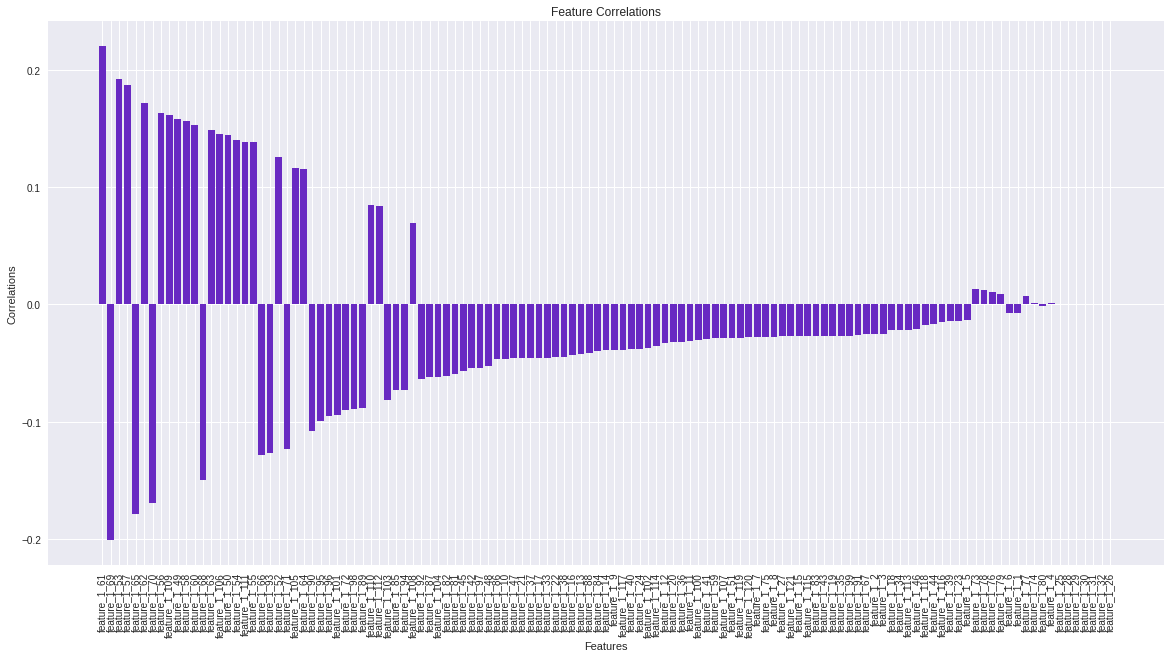

In [23]:
names, correlations = pipe.features.correlations()

plt.subplots(figsize=(20, 10))

plt.bar(names, correlations, color='#6829c2')

plt.title('Feature Correlations')
plt.xlabel('Features')
plt.ylabel('Correlations')
plt.xticks(rotation='vertical')
plt.show()

In [30]:
pipe.features.to_sql().save("imdb_features", split=True)

__Feature importances__
 
Feature importances are calculated by analyzing the improvement in predictive accuracy on each node of the trees in the XGBoost predictor. They are then normalized, so that all importances add up to 100%.

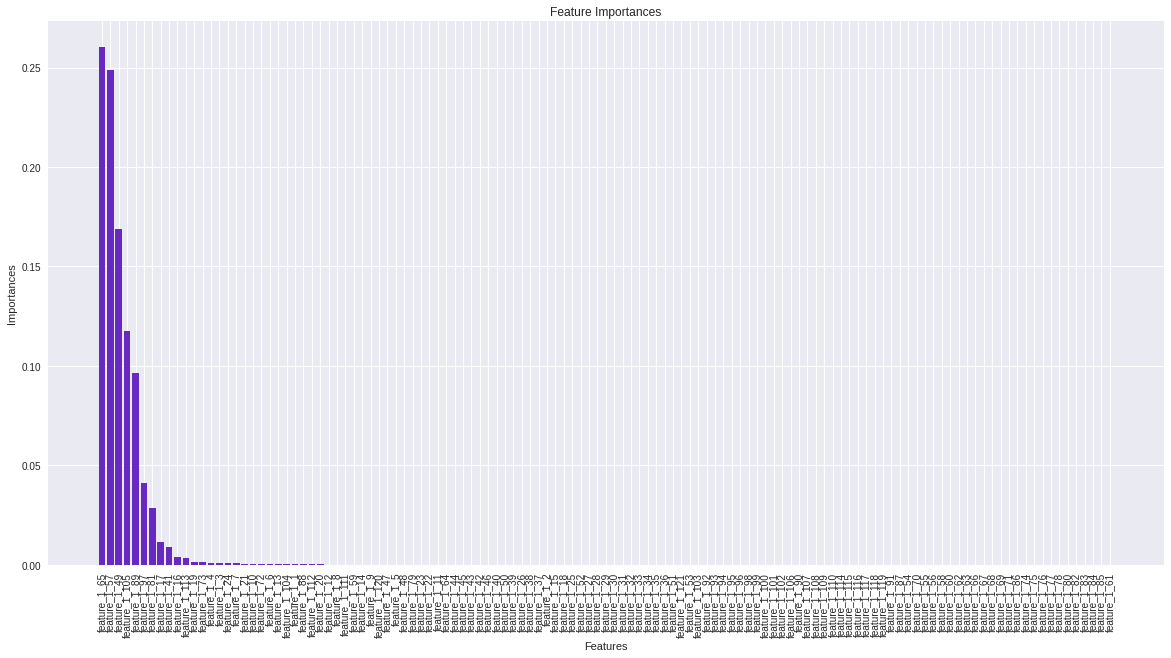

In [25]:
names, importances = pipe.features.importances()

plt.subplots(figsize=(20, 10))

plt.bar(names, importances, color='#6829c2')

plt.title('Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importances')
plt.xticks(rotation='vertical')
plt.show()

most_important = names[0]

__Column importances__

Because getML uses relational learning, we can apply the principles we used to calculate the feature importances to individual columns as well.

As we can see, most of the predictive accuracy is drawn from the roles played by the actors. This suggests that the text fields contained in this relational database have a higher impact on predictive accuracy than for most other data sets.

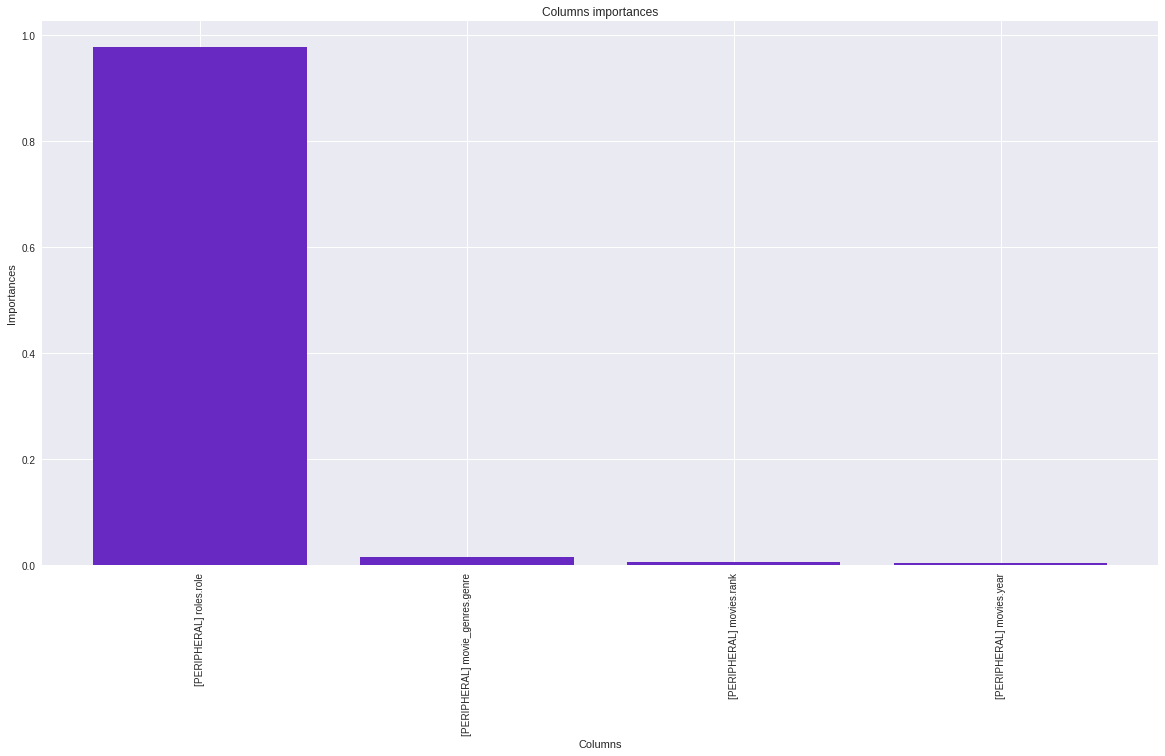

In [26]:
names, importances = pipe.columns.importances()

plt.subplots(figsize=(20, 10))

plt.bar(names, importances, color='#6829c2')

plt.title('Columns importances')
plt.xlabel('Columns')
plt.ylabel('Importances')
plt.xticks(rotation='vertical')
plt.show()

__Transpiling the learned features__

We can also transpile the learned features to SQLite3 code. We want to show the two most important features: So we sort the features container and request the features' respective sql transpilations.

In [27]:
pipe.features.sort(by="importance")[0].sql

```sql
DROP TABLE IF EXISTS "FEATURE_1_65";

CREATE TABLE "FEATURE_1_65" AS
SELECT AVG( CASE WHEN t2."role" LIKE '%himself%' THEN 1 ELSE 0 END ) AS "feature_1_65",
       t1.rowid AS "rownum"
FROM "actors" t1
LEFT JOIN "roles" t2
ON t1."id" = t2."actor_id"
LEFT JOIN "movies" t3
ON t2."movie_id" = t3."id"
GROUP BY t1.rowid;
```

In [28]:
pipe.features.sort(by="importance")[1].sql

```sql
DROP TABLE IF EXISTS "FEATURE_1_57";

CREATE TABLE "FEATURE_1_57" AS
SELECT AVG( CASE WHEN t2."role" LIKE '%herself%' THEN 1 ELSE 0 END ) AS "feature_1_57",
       t1.rowid AS "rownum"
FROM "actors" t1
LEFT JOIN "roles" t2
ON t1."id" = t2."actor_id"
LEFT JOIN "movies" t3
ON t2."movie_id" = t3."id"
GROUP BY t1.rowid;
```

### 2.7 Benchmarks

State-of-the-art approaches on this data set perform as follows:

| Approach                      | Study                      | Accuracy     | AUC     |
| :--------------------------   | :------------------------  | -----------: | ------: |
| Relational dependency network | Neville and Jensen (2007)  | --           |    86%  |
| Relational dependency network | Neville and Jensen (2003)  | 81.98%       | --      |
| Wordification                 | Perovšek et al. (2015)     | 81.93%       |    75%  |
| Relational Probability Tree   | Neville et al. (2003)      | 80%          | --      |

As we can see, the performance of the relboost algorithm, as used in this notebook, compares favorably to these benchmarks, solidly outperforming Neville and Jensen (2007), which was published in the Journal of Machine Learning Research.

| Approach                      | Accuracy     | AUC     |
| :---------------------------- | -----------: | ------: |
| relboost (tuned)              | 85.25%       | 92.87%  |
| relboost (default parameters) | 83.78%       | 91.52%  |

## 3. Conclusion

In this notebook we have demonstrated how getML can be applied to text fields. We have demonstrated the our  approach outperforms state-of-the-art relational learning algorithms on the IMDb dataset.

## References

Motl, Jan, and Oliver Schulte. "The CTU prague relational learning repository." arXiv preprint arXiv:1511.03086 (2015).
    
Neville, Jennifer, and David Jensen. "Relational dependency networks." Journal of Machine Learning Research 8.Mar (2007): 653-692.
    
Neville, Jennifer, and David Jensen. "Collective classification with relational dependency networks." Workshop on Multi-Relational Data Mining (MRDM-2003). 2003.
    
Neville, Jennifer, et al. "Learning relational probability trees." Proceedings of the Ninth ACM SIGKDD international conference on Knowledge discovery and data mining. 2003.
    
Perovšek, Matic, et al. "Wordification: Propositionalization by unfolding relational data into bags of words." Expert Systems with Applications 42.17-18 (2015): 6442-6456.

# Next Steps

This tutorial went through the basics of applying getML to relational data that contains columns with freeform text. If you want to learn more about getML, here are some additional tutorials and articles that will help you:

__Tutorials:__
* Just head back to the [notebook overview](welcome.md) and choose one of the remaining examples.

__User Guides__ (from our [documentation](https://docs.getml.com/latest/)):
* [Feature learning with Multirel](https://docs.getml.com/latest/user_guide/feature_engineering/feature_engineering.html#multirel)
* [Feature learning with Relboost](https://docs.getml.com/latest/user_guide/feature_engineering/feature_engineering.html#relboost)

# Get in contact

If you have any question schedule a [call with Alex](https://go.getml.com/meetings/alexander-uhlig/getml-demo), the co-founder of getML, or write us an [email](team@getml.com). Prefer a private demo of getML? Just contact us to make an appointment.